# [LEGALST-123] Lab 14: Feature Selection

This lab will cover feature selection in order to train a machine learning model using `scikit-learn`. With complex datasets, we can run into the problems of overfitting your model and a long run time if all features were to be used. Feature selection is used in machine learning to avoid those type of issues. 

Estimated time: 35 minutes

### Table of Contents
[The Data](#section data)<br>
1 - [Second Model](# section 1)<br>
2 - [Intro to Feature Removal Intuition](#section 2)<br>
3 - [Checking Results](#section 3)<br>


In [1]:
# load all libraries 

import numpy as np
#from datascience import *
import datetime as dt
import pandas as pd
import seaborn as sns

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

#scikit-learn
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn import preprocessing


from sklearn import metrics

## The Data: Bike Sharing<a id='section data'></a>

By now, you have been exposed to hte bike sharing dataset several times. This lab's data describes one such bike sharing system in Washington D.C., from UC Irvine's Machine Learning Repository.

Information about the dataset: http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [2]:
bike = pd.read_csv('data/day.csv', index_col=0)
# reformat the date column to integers that represent the day of the year, 001-366
bike['dteday'] = pd.to_datetime(bike['dteday'].unique()).strftime('%j')

# drop casual and registered riders because we want to predict the number of total riders
bike = bike.drop(['casual', 'registered'], axis = 1)

bike.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
instant,,,,,,,,,,,,,
1,001,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2,002,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
3,003,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
4,004,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
5,005,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


If you need to become familiar with this data set again, feel free to refer back to lab 2-22.

To see how feature selection can change the accuracy for the better or worse, let's start by making a Linear Regression classifer that uses all features. This will act as our baseline.

This cell also splits the data into train, validation, and test sets. Just like for model selection, we'll train our data on the training set, use the validation data to compare accuracy for different possible models (in this case, different combinations of features), and only use the test data once after we've finalized our model.

In [3]:
# the features used to predict riders
X = bike.drop(['cnt'], axis = 1)

# the number of riders (target)
y = bike['cnt']

# set the random seed
np.random.seed(10)

# split the data with 0.20 proportion for test size
# train_test_split returns 4 values: X_train, X_test, y_train, y_test 
X, X_test, y, y_test = train_test_split(X, y,
                                                    train_size=0.80, test_size=0.20)
# split the remaining data with 0.75 proportion for train size and 0.25 for validation size
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

# create a linear regression model
first_model_reg = LinearRegression()

#fit your model
first_model = first_model_reg.fit(X_train, y_train)

#predict X_train using your model
first_pred = first_model.predict(X_train)

#predict X_val using your model
val_pred = first_model.predict(X_val)


In order to check the error between the predicted values and the actual values, We have defined the root mean square error for you. Recall that the equation is the square root of the average differences between the predicted and actual values.

In [4]:
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [5]:
# check the rmse of your models

first_train_error = rmse(first_pred, y_train)

first_val_error = rmse(val_pred, y_val)

print("Training RMSE:", first_train_error)
print("Validation RMSE:", first_val_error)

Training RMSE: 854.5479409431214
Validation RMSE: 851.1432410273414


## Section 1: Second Model

Our training and test errors seem to be pretty high. Let's see how we can improve our model by using feature selection. This process is often accompanied by lots of Exploratory Data Analysis (EDA). First we will look at which features correlate to our target feature (`cnt`).


**Question 1.1:** Plot a few EDA yourself to become familar with the correlation values between certain features with the number of riders.

**hint:** the `.corr()` method can be called on a dataframe to get the correlation matrix, and heat maps are helpful to visualize correlation (use `sns.heatmap(<data>)`)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.100659


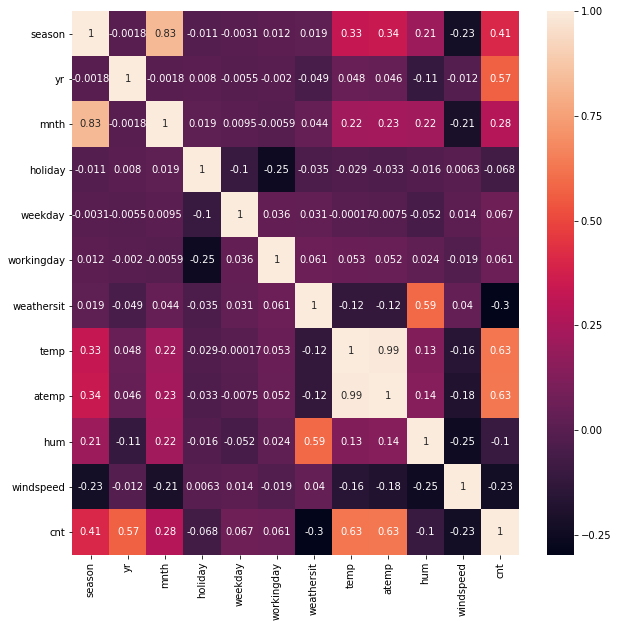

In [6]:
corrmat = bike.corr()
plt.figure(figsize=(10,10))
g = sns.heatmap(corrmat, annot=True)
corrmat

**Question 1.2:** Looking at your EDA, how will that help you select which features to use?

*Answer:* sample answer
- Looking at the correlations between all features and cnt, I would pick the ones with correlation values higher than 0.50

**Question 1.3:** List out features that would probably be important to select for your model. Make sure to not include the rider count in your features list.

In [7]:
features = ["yr", "temp", "atemp"]
features

['yr', 'temp', 'atemp']

**Question 1.4:** Now create a `linear regression` model with the features that you have selected to predict the number of riders(`cnt`). 

First, create new subsets of the training and validation data that only contain your chosen features. Then, initialize and fit your model to this new training data and use the model to predict the number of riders for the training set.

Remember: any transformations you do on the training data also need to be done for the validation data (and the test data, if you end up using this model).

*Note that Lasso and Ridge models would use the same steps below.*

In [8]:
# the features used to predict riders
X_train_my_feats = X_train[features]
X_val_my_feats = X_val[features]


In [9]:
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train_my_feats, y_train)

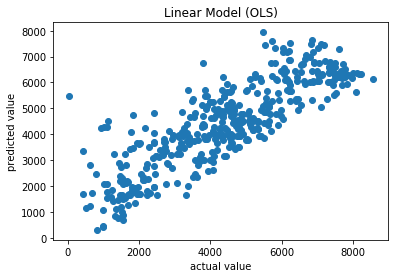

In [10]:
# predict the number of riders

lin_pred = lin_model.predict(X_train_my_feats)

# plot the residuals on a scatter plot
plt.scatter(y_train, lin_pred)

plt.title('Linear Model (OLS)')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

**Question 1.5:** What is the rmse for both the prediction of X_train and X_val?

In [11]:
#predict your X_test here
lin_val_pred = lin_model.predict(X_val_my_feats)

second_train_error = rmse(lin_pred, y_train)
second_val_error = rmse(lin_val_pred, y_val)

print("Training RMSE:", second_train_error)
print("Test RMSE:", second_val_error)

Training RMSE: 1048.2533725328765
Test RMSE: 1044.2227479282615


hmm... maybe our selected features did not improve the error as much. Let's see how we can improve our model.

## Section 2: Introduction to Feature Removal Intuition<a id = 'section 2'></a>

As a good rule of thumb, we typically wish to pick features that are highly correlated with the target column. Also, even though not relevant to the bike sharing dataset, it is often best to remove columns that contain a high ratio of null values. However, sometimes null values represent 0 instead of data actually missing! So always be on the look out when you have to clean data.

Of course, with any tedious and error prone process there is always a short cut that reduces time and human error. In part 1, you used your own intuition to pick out features that correlate the highest with the target feature. However, we can use `scikit-learn` to help pick the important features for us. 

Feature selection methods can give you useful information on the relative importance or relevance of features for a given problem. You can use this information to create filtered versions of your dataset and increase the accuracy of your model.

### Remove Features with Low Variance

As you might remember from Data-8 (or other introductory statistics classes), the **variance** of data can give an idea of how spread out it is. This can be useful for feature selection. In removing features with low variance, all features whose variance does not meet some threshold are removed- the idea being that if a feature has low variability, it will be less helpful in prediction.

**Question 2.1:** What is the current shape of X_train?

In [12]:
# code answer here
X_train.shape

(438, 12)

Use `VarianceThreshold` to filter out features that are below a 0.1 threshold. 

Then you can use `transform` on the X_train. This will select features that match the threshold.

In [14]:
#use VarianceThreshold 
sel = VarianceThreshold(threshold = 0.1)
sel.fit(X_train)

# Subset features with transform
X_new_train = sel.transform(X_train)



#make sure to also transform X_test so it will match dimensions of X_train
X_new_val = sel.transform(X_val)

Check the shape of the transformed training data. How many features were removed?

In [15]:
#notice how many features are then selected compared to X_train's original features
X_new_train.shape

(438, 7)

Now, create and fit a new Linear Regression model on these features and make predictions for `X_new_train` and `X_new_val`

In [17]:
#Create a new Linear Regression model for your X_new. Recall that X_new is the X_train with selected features.
new_lin_reg = LinearRegression()

# fit the model
new_lin_model = new_lin_reg.fit(X_new_train, y_train)

#predict X_new
new_lin_pred = new_lin_model.predict(X_new_train)

#predict X_new_validation
new_val_pred = new_lin_model.predict(X_new_val)

<div class="alert alert-danger">

**STOP!**
There is something very sketchy about using this method for feature removal on this particular data set. Can you say why? Hint: look again at the intuition behind the method, the kinds of features in the data set, and the variance of each feature (easily gotten using `sel.variances_`).
</div>   

In [18]:
# check the variances for each feature
sel.variances_

array([1.12764585e+04, 1.27274765e+00, 2.49979150e-01, 1.21478545e+01,
       3.51952628e-02, 3.87417381e+00, 2.13220116e-01, 3.15532412e-01,
       3.26738113e-02, 2.59286662e-02, 2.19105059e-02, 6.04712459e-03])

#### The Issues
1. Our bike sharing data includes variables with many *different units*: Celsius temperature, windspeed, and  humidity. Comparing variances for features with different scales is like comparing apples to oranges- if they have difference variances, that might just be due to the fact that they're measured on different scales.
2. Some of our features are *categorical*: things like 'holiday' or 'year' have integer values that represent categories rather than vary on a continuous scale. For example, although we have holiday values of 0 and 1, we can't have a holiday of anything in between (like 0.5) because a day is either a holiday (1) or it isn't (0). This means the variance for these features isn't meaningful in the same way as for the numerical features.

So why did we have you do the previous section if it isn't valid? Variance thresholds may be a valuable feature removal tool if you're working with data that has many features with comparable units- for example, data for an athletic competition where event results for many different events are measured in milliseconds. Knowing the process may come in handy for other data sets or projects. Just be sure to take these results with a grain of salt, since we know the features would have been filtered out in a somewhat arbitrary way.

**Question 2.2:** How does your root mean square error change compared to your model in section 1? Try changing the threshold to different values to see how it affects the accuracy.

*Answer:*

In [19]:
third_train_error = rmse(new_lin_pred, y_train)
third_val_error = rmse(new_val_pred, y_val)

print("Training RMSE:", third_train_error)
print("Validation RMSE:", third_val_error)

Training RMSE: 1250.147896260331
Validation RMSE: 1231.9412995112266


### Recursive Feature Elimiation with scikit-learn

According to [Feature Selection in Python with Scikit-Learn](https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/), recursive feature elimination works by “recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.”

So, recursive feature elimination takes care of much of the trial-end-error feature removal process for you. `RFE` takes a model (in this case, a `LinearRegression()` object) and the desired number of features to keep. It is then fit on the training X and y.

In [20]:
# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()

# create the RFE model and select 10 attributes
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=10, step=1, verbose=0)

To check which features have been selected, we can use rfe.support_ to show mask of selected features.

In [ ]:
print(rfe.support_)

The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

In [ ]:
print(rfe.ranking_)

In [ ]:

# using rfe, predict your training set
new_pred = rfe.predict(X_train)

# now predict your test set
new_val_pred = rfe.predict(X_val)


In [ ]:
# time for errors
fourth_train_error = rmse(new_pred, y_train)
fourth_val_error = rmse(new_val_pred, y_val)

print("Training RMSE:", fourth_train_error)
print("Validation RMSE:", fourth_val_error)

**Question 2.3:** How does recursive feature elimination change your error? Does the error get better or worse when you tell RFE to use less than 10 or more than 10 attributes?

*Answer:* Use the rmse equation to explain.

### Feature Importance

Feature importance is selecting features that are most important from a previous classifier. For example, selecting the most important features from a number of randomized decision trees. "A decision tree can be used to visually and explicitly represent decisions and decision making. As the name goes, it uses a tree-like model of decisions." If you would like to read more, feel free to [click here](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052). The main idea behind using the randomized trees is to use many of them to perform prediction. This helps the model to be more robust.

Methods that use ensembles of decision trees (like `Random Forest` or `Extra Trees`) can also compute the relative importance of each attribute. These importance values can be used to inform a feature selection process. In this lab, we will be using `Extra Trees`, Random forest will be introduced in the next lab.

Below shows the construction of an Extra Trees ensemble of the bike share dataset and the display of the relative feature importance.

Once you use `ExtraTreesClassifer` to create a new model, fit the model. Afterwards, you can use `SelectFromModel` to select features using the classifier. Make sure to `transform` your X_train to obtain the selected important features.

In [ ]:
# Fits a number of randomized decision trees. Use 15 estimators (this value was arbitrarily chosen)
# this allows us to select features
model = ExtraTreesClassifier(n_estimators = 15)

#fit your model
model.fit(X_train, y_train)

# Select the important features of previous model
sel = SelectFromModel(model, prefit=True)

# Subset features by calling transform on your training X
select_X_train = sel.transform(X_train)

# We want to create a train model
sel_model = ExtraTreesClassifier(n_estimators = 15)
sel_model.fit(select_X_train, y_train)


In [ ]:
#predict X_train
y_train_pred = sel_model.predict(select_X_train)

# we must also select features from X_test to have number of features match up with the model
select_X_val = sel.transform(X_val)

y_pred = sel_model.predict(select_X_val)

fifth_train_error = rmse(y_train_pred, y_train)
fifth_val_error = rmse(y_pred, y_val)

print("Training RMSE:", fifth_train_error)
print("Validation RMSE:", fifth_val_error)

**Question 2.4:** How does using the Extra Trees change your error? Does the error get better or worse when you change the number of estimators?

*Answer:* Depends on the errors students received.

## Section 3: Checking Results<a id = 'section 3'></a>

Note that since Linear Regression is not the only model option, you can use the above methods to select features for many models, including `Lasso` or `Ridge`.

**Question 3.1:** Within the scope of this class, what other methods besides feature selection can be used to improve estimation?

*Answer:* possible answers
- testing multiple models
- averging models
- stacking models
- change number of attributes in Recursive Feature Elimiation method
- increase number of estimates in Feature Importance method

**Question 3.1:** Now that we have gone through different methods of feature selection, let's see how the error changes with each method. We have created the dataframe for you, now graph it!

In [ ]:
labels = ['all_features', 'own_selection', 'variance_theshold', 'rfe', 'important']
methods = pd.DataFrame(columns = labels)
methods['all_features'] = [first_train_error, first_val_error]
methods['own_selection'] = [second_train_error, second_val_error]
methods['variance_theshold'] = [third_train_error, third_val_error]
methods['rfe'] = [fourth_train_error, fourth_val_error]
methods['important'] = [fifth_train_error, fifth_val_error]

methods = methods.rename(index={0: 'train'})
methods = methods.rename(index={1: 'validation'})
methods

In [ ]:
#sample plot

methods.plot.bar()

**Question**: How do the different error rates compare for the different methods of feature selection? Which ones change significantly for training and validation data?

## Bibliography

 - Brownlee Jason, An Introduction to Feature Selection. https://machinelearningmastery.com/an-introduction-to-feature-selection/
 - Brownlee Jason, Feature Selection in Python with Scikit-Learn. https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/
 - Asaithambi Sudharsan, Why, How and When to apply Feature Selection. https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2
 - Use of `Bike Share` data set adapted from UC Irvine's Machine Learning Repository. http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
 - Some code adapted from Celia Siu: https://csiu.github.io/blog/update/2017/03/06/day10.html

----
Notebook developed by: Tina Nguyen

Data Science Modules: http://data.berkeley.edu/education/modules